In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")
project_base="/home/username/haiku/"

In [3]:
with open(project_base+'/dataset/input_formatted.txt') as f:
    data = f.readlines()

In [4]:
import requests 
import pandas as pd
from itertools import compress
df = pd.DataFrame(
    data,
    columns=['data']
    )

haikus = df.data.copy()

In [5]:
bs = 32

In [6]:
max_flavour = max([len(tokenizer.encode(haiku)) for haiku in haikus])

In [7]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class HaikuDataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_flavour):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the flavour text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [8]:
from torch.utils.data import random_split

dataset = HaikuDataset(haikus, tokenizer, max_length=max_flavour)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 12550 samples for training, and 1395 samples for validation testing'

In [9]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

In [10]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [11]:
epochs = 4
warmup_steps = 1e2
sample_every = 100

In [12]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [13]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [14]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 100 of 393. Loss:2.0328567028045654. Time:0:00:19
Example output:  bipartisan<s> lightning storm + through the garden </s>



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 200 of 393. Loss:1.7656956911087036. Time:0:00:38
Example output:  increasing<s> after a funeral + the sound of a crow calling + from a grave </s>



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 300 of 393. Loss:1.6095466613769531. Time:0:00:56
Example output: day<s> old school + all you can see + before me </s>

Average Training Loss: 2.8346107767435127. Epoch time: 0:01:14
Validation loss: 1.660438602620905. Validation Time: 0:00:02
Beginning epoch 2 of 4


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 100 of 393. Loss:1.4790865182876587. Time:0:00:19
Example output:  Hang<s> the river's surface + on a white plow? + the sun </s>



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 200 of 393. Loss:1.5505626201629639. Time:0:00:38
Example output:  foods<s> spring rain... + i try to make up + my mind </s>



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 300 of 393. Loss:1.4997425079345703. Time:0:00:58
Example output:  trail<s> first light + a cold night + in our hotel rooms </s>

Average Training Loss: 1.5676072526524085. Epoch time: 0:01:15
Validation loss: 1.6385540501637892. Validation Time: 0:00:02
Beginning epoch 3 of 4


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 100 of 393. Loss:1.3959490060806274. Time:0:00:18
Example output: intend<s> spring dawn - + a boy's eyes + a pale purple </s>



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 200 of 393. Loss:1.3878724575042725. Time:0:00:37
Example output:  surround<s> winter night + so loud and so loud + the blue dawn </s>



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 300 of 393. Loss:1.4130899906158447. Time:0:00:55
Example output:  reflex<s> in the back alley + the scent of garlic + on my lips </s>

Average Training Loss: 1.4379507430637155. Epoch time: 0:01:12
Validation loss: 1.6436751511963932. Validation Time: 0:00:02
Beginning epoch 4 of 4


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 100 of 393. Loss:1.3303910493850708. Time:0:00:18
Example output:  display<s> rainstorm clouds--- + a red spider + in the web </s>



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 200 of 393. Loss:1.3190563917160034. Time:0:00:36
Example output:  pastor<s> cold May morning + i stand by + my beliefs </s>



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 300 of 393. Loss:1.3570098876953125. Time:0:00:54
Example output:  illicit<s> crescent moon + a spider and + the spiderlings </s>

Average Training Loss: 1.3359831407779956. Epoch time: 0:01:12
Validation loss: 1.6644088923931122. Validation Time: 0:00:02
Total training took 0:05:01


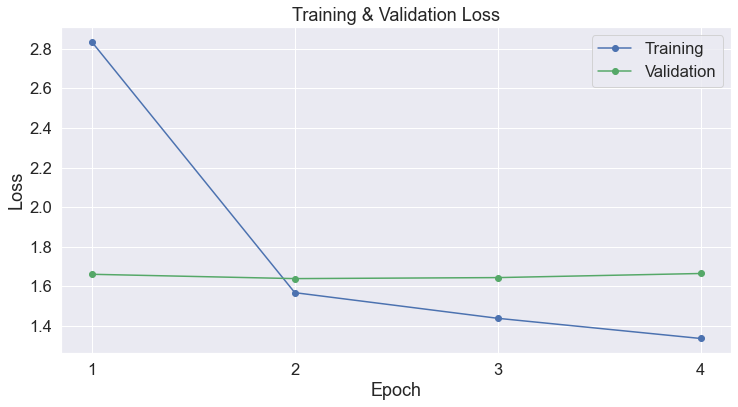

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
output_dir = project_base+'/gpt2-haiku'

tokenizer.save_pretrained(output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
#model_to_save = model.module if hasattr(model, 'module') else model
#model_to_save.save_pretrained(output_dir)
#tokenizer.save_pretrained(output_dir)
# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

In [120]:
#ONLY USE IF LOADING FROM SAVED

import time
from transformers import GPT2LMHeadModel, GPT2Config
import torch
from transformers import GPT2Tokenizer
input_dir = project_base+'/gpt2-haiku3'
model = GPT2LMHeadModel.from_pretrained(
    input_dir,
    output_hidden_states=True
)
#device = torch.device("cuda")
device = torch.device("cpu")
#model.to(device)

# load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(input_dir)

In [18]:
#remaining cells are for evaluation purposes only

import re
import math

# used for unseen words in training vocabularies
UNK = None
# sentence start and end
SENTENCE_START = "<s>"
SENTENCE_END = "</s>"

def read_sentences_from_file(file_path):
    with open(file_path, "r") as f:
        return [re.split("\s+", line.rstrip('\n')) for line in f]

class UnigramLanguageModel:
    def __init__(self, sentences, smoothing=False):
        self.unigram_frequencies = dict()
        self.corpus_length = 0
        for sentence in sentences:
            for word in sentence:
                self.unigram_frequencies[word] = self.unigram_frequencies.get(word, 0) + 1
                if word != SENTENCE_START and word != SENTENCE_END:
                    self.corpus_length += 1
        # subtract 2 because unigram_frequencies dictionary contains values for SENTENCE_START and SENTENCE_END
        self.unique_words = len(self.unigram_frequencies) - 2
        self.smoothing = smoothing

    def calculate_unigram_probability(self, word):
            word_probability_numerator = self.unigram_frequencies.get(word, 0)
            word_probability_denominator = self.corpus_length
            if self.smoothing:
                word_probability_numerator += 1
                # add one more to total number of seen unique words for UNK - unseen events
                word_probability_denominator += self.unique_words + 1
            return float(word_probability_numerator) / float(word_probability_denominator)

    def calculate_sentence_probability(self, sentence, normalize_probability=True):
        sentence_probability_log_sum = 0
        for word in sentence:
            if word != SENTENCE_START and word != SENTENCE_END:
                word_probability = self.calculate_unigram_probability(word)
                sentence_probability_log_sum += math.log(word_probability, 2)
        return math.pow(2, sentence_probability_log_sum) if normalize_probability else sentence_probability_log_sum                

    def sorted_vocabulary(self):
        full_vocab = list(self.unigram_frequencies.keys())
        full_vocab.remove(SENTENCE_START)
        full_vocab.remove(SENTENCE_END)
        full_vocab.sort()
        full_vocab.append(UNK)
        full_vocab.append(SENTENCE_START)
        full_vocab.append(SENTENCE_END)
        return full_vocab

class BigramLanguageModel(UnigramLanguageModel):
    def __init__(self, sentences, smoothing=False):
        UnigramLanguageModel.__init__(self, sentences, smoothing)
        self.bigram_frequencies = dict()
        self.unique_bigrams = set()
        for sentence in sentences:
            previous_word = None
            for word in sentence:
                if previous_word != None:
                    self.bigram_frequencies[(previous_word, word)] = self.bigram_frequencies.get((previous_word, word),
                                                                                                 0) + 1
                    if previous_word != SENTENCE_START and word != SENTENCE_END:
                        self.unique_bigrams.add((previous_word, word))
                previous_word = word
        self.unique__bigram_words = len(self.unigram_frequencies)

    def calculate_bigram_probabilty(self, previous_word, word):
        bigram_word_probability_numerator = self.bigram_frequencies.get((previous_word, word), 0)
        bigram_word_probability_denominator = self.unigram_frequencies.get(previous_word, 0)
        if self.smoothing:
            bigram_word_probability_numerator += 1
            bigram_word_probability_denominator += self.unique__bigram_words
        return 0.0 if bigram_word_probability_numerator == 0 or bigram_word_probability_denominator == 0 else float(
            bigram_word_probability_numerator) / float(bigram_word_probability_denominator)

    def calculate_bigram_sentence_probability(self, sentence, normalize_probability=True):
        bigram_sentence_probability_log_sum = 0
        previous_word = None
        for word in sentence:
            if previous_word != None:
                bigram_word_probability = self.calculate_bigram_probabilty(previous_word, word)
                bigram_sentence_probability_log_sum += math.log(bigram_word_probability, 2)
            previous_word = word
        return math.pow(2,
                        bigram_sentence_probability_log_sum) if normalize_probability else bigram_sentence_probability_log_sum

# calculate number of unigrams & bigrams
def calculate_number_of_unigrams(sentences):
    unigram_count = 0
    for sentence in sentences:
        # remove two for <s> and </s>
        unigram_count += len(sentence) - 2
    return unigram_count

def calculate_number_of_bigrams(sentences):
        bigram_count = 0
        for sentence in sentences:
            # remove one for number of bigrams in sentence
            bigram_count += len(sentence) - 1
        return bigram_count

# print unigram and bigram probs
def print_unigram_probs(sorted_vocab_keys, model):
    for vocab_key in sorted_vocab_keys:
        if vocab_key != SENTENCE_START and vocab_key != SENTENCE_END:
            print("{}: {}".format(vocab_key if vocab_key != UNK else "UNK",
                                       model.calculate_unigram_probability(vocab_key)), end=" ")
    print("")

def print_bigram_probs(sorted_vocab_keys, model):
    print("\t\t", end="")
    for vocab_key in sorted_vocab_keys:
        if vocab_key != SENTENCE_START:
            print(vocab_key if vocab_key != UNK else "UNK", end="\t\t")
    print("")
    for vocab_key in sorted_vocab_keys:
        if vocab_key != SENTENCE_END:
            print(vocab_key if vocab_key != UNK else "UNK", end="\t\t")
            for vocab_key_second in sorted_vocab_keys:
                if vocab_key_second != SENTENCE_START:
                    print("{0:.5f}".format(model.calculate_bigram_probabilty(vocab_key, vocab_key_second)), end="\t\t")
            print("")
    print("")

# calculate perplexty
def calculate_unigram_perplexity(model, sentences):
    unigram_count = calculate_number_of_unigrams(sentences)
    sentence_probability_log_sum = 0
    for sentence in sentences:
        try:
            sentence_probability_log_sum -= math.log(model.calculate_sentence_probability(sentence), 2)
        except:
            sentence_probability_log_sum -= float('-inf')
    return math.pow(2, sentence_probability_log_sum / unigram_count)

def calculate_bigram_perplexity(model, sentences):
    number_of_bigrams = calculate_number_of_bigrams(sentences)
    bigram_sentence_probability_log_sum = 0
    for sentence in sentences:
        try:
            bigram_sentence_probability_log_sum -= math.log(model.calculate_bigram_sentence_probability(sentence), 2)
        except:
            bigram_sentence_probability_log_sum -= float('-inf')
    return math.pow(2, bigram_sentence_probability_log_sum / number_of_bigrams)


def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

def countSyllablesEN(theText):

    cleanText = ""
    for ch in theText:
        if ch in "abcdefghijklmnopqrstuvwxyz'’":
            cleanText += ch
        else:
            cleanText += " "

    asVow    = "aeiouy'’"
    dExep    = ("ei","ie","ua","ia","eo")
    theWords = cleanText.lower().split()
    if (len(theWords) == 0):
        theWords = "a"
    allSylls = 0
    for inWord in theWords:
        nChar  = len(inWord)
        nSyll  = 0
        wasVow = False
        wasY   = False
        if nChar == 0:
            continue
        if inWord[0] in asVow:
            nSyll += 1
            wasVow = True
            wasY   = inWord[0] == "y"
        for c in range(1,nChar):
            isVow  = False
            if inWord[c] in asVow:
                nSyll += 1
                isVow = True
            if isVow and wasVow:
                nSyll -= 1
            if isVow and wasY:
                nSyll -= 1
            if inWord[c:c+2] in dExep:
                nSyll += 1
            wasVow = isVow
            wasY   = inWord[c] == "y"
        if inWord.endswith(("e")):
            nSyll -= 1
        if inWord.endswith(("le","ea","io")):
            nSyll += 1
        if nSyll < 1:
            nSyll = 1
        # print("%-15s: %d" % (inWord,nSyll))
        allSylls += nSyll

    return allSylls/len(theWords)

def preprocess(haiku):
    #don?t don't
    haiku = haiku.replace('don?t','don\'t')
    #i?m i'm
    haiku = haiku.replace('i?m','i\'m')
    #i?ve i've
    haiku = haiku.replace('i?ve','i\'ve')
    haiku = haiku.replace('?','')
    haiku = haiku.replace('-','')
    haiku = haiku.replace('.','')
    #haiku = haiku.encode("ascii", "ignore")
    return haiku

dataset = read_sentences_from_file(project_base+"/tests/original_dataset.txt")
dataset_model_smoothed = BigramLanguageModel(dataset, smoothing=True)

In [19]:
model.eval()

prompt = "<|startoftext|>last time I saw her"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=10
                                )


def score(haiku):
    
    #deviation from perfect size
    score = 1
    lines = haiku.split("+")
    if len(lines) < 3:
        score -= 1
    else:
        for n in range(3):
            count = 0
            if len(lines[n]) > 40:
                score -= 1
            else:
                if str(lines[n]) != 0:
                    words = lines[n].split(" ")
                    for word in words:
                        if len(str(word)) != 0:
                            count += countSyllablesEN(str(word))
                #award .0 points when distance from perfection if > 3
                if n == 0 or n == 2:
                    diff = abs(5 - count)
                if n == 1:
                    diff = 7 - count
                #award .6 points for every "perfect" line
                if diff <= 3:
                    score += .6 - (diff * 0.2)
    
    #repetition
    haiku = haiku.replace('+','')
    wc = word_count(haiku)
    for w in wc:
        #curtail 1 point for every word longer than 3 chars that appears more than once
        if wc[w] > 1 and len(w)>3:
            score -= 1
    
    
    #sensicality
    dataset_test = re.split("\s+", "<s> "+haiku+" </s>".rstrip('\n'))
    perp = calculate_bigram_perplexity(dataset_model_smoothed, dataset_test) -13000
    #print("perp: "+str(perp))
    if perp < 2100:
        score += 1

    return score


tbs = []

for i, sample_output in enumerate(sample_outputs):
    h = tokenizer.decode(sample_output, skip_special_tokens=True)
    print(h)
    h = preprocess(h)
    s = score(h)
    tbs.append( (h, s) )


tbs.sort(key=lambda x: x[1], reverse=True)
#print (tbs)
h = tbs[0][0] + tbs[1][0] + tbs[2][0] + tbs[3][0]
print (h)

    

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


last time I saw her + her belly button clings + to the floorboards </s>

last time I saw her + summer's end </s>

last time I saw her + she's gone </s>

last time I saw her + she still wearing her grey dress </s>

last time I saw her + he would never return my letter </s>

last time I saw her + the same way twice </s>

last time I saw her - + the long gray beard + of her ex-wife </s>

last time I saw her + one small change + in the air </s>

last time I saw her + her belly button undone </s>

last time I saw her + in her dark red hair + autumn wind </s>

last time I saw her + her belly button clings + to the floorboards </s>
last time I saw her  + the long gray beard + of her exwife </s>
last time I saw her + in her dark red hair + autumn wind </s>
last time I saw her + one small change + in the air </s>



In [128]:
#Neuron View

In [ ]:
from bertviz.transformers_neuron_view import GPT2Model, GPT2Tokenizer
from bertviz.neuron_view import show

In [ ]:

model_type = 'gpt2'
model_version = 'gpt2'
model2 = GPT2LMHeadModel.from_pretrained(
        project_base+'/gpt2-haiku',
        output_hidden_states=True
    )
model2 = GPT2Model.from_pretrained(model_version)
tokenizer = GPT2Tokenizer.from_pretrained(model_version)
text = "consciousness to smell + the sun-drenched forest + that never was"
show(model2, model_type, tokenizer, text, display_mode='dark')